# Convolutional Neural Network for Predicting Room Type and Room Quality

The team's hypothesis is that images communicate information about the quality of the listing. This can be the key that differentiates why one 2 bed-2 bath is worth 50,000USD more than another 2 bed-2 bath on the same block.

Using a labeled dataset of 40,000~ images created by combination of Azure, OpenAI, and human labeling, the team will create 6 neural networks.

* The first neural network predicts which kind of room the image is (6 classes: Bedroom, Bathroom, Kitchen, Living Room, Location Exterior, Other).
* The next 5 networks predicts a quality ranking on a score of 1-10 for each of the room types (excluding the class 6th class "Other").

<div class="alert alert-block alert-info">
<b>Note:</b> While the goal will be to create the best fitting, generalizable model, it's okay if this is not perfect. The predicted labels that will come from this model will help create 5-10 predictors for the final Zillow pricing model (out of 100+ predictors).
</div>

The output of this notebook will be a series of `model.keras` files for each neural network, which will then we moved to a separate workflow to handle labeling all 6 million of the photos in the dataset.

### Step 0: Import packages.

I'll be using tensorflow for my neural network, as well as a handful of sklearn utilities to help prepare and measure performance of this classification prediction scenario.

In [1]:
# Install the version of numpy / scipy that that are required for this notebook.
!pip install numpy==1.26.4 scipy==1.13.1

  Obtaining dependency information for numpy==1.26.4 from https://files.pythonhosted.org/packages/4b/d7/ecf66c1cd12dc28b4040b15ab4d17b773b87fa9d29ca16125de01adb36cd/numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.2
ERROR: Cannot uninstall numpy 1.26.2, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps numpy==1.26.2'.


In [2]:
# Standard data manipulation.
import numpy as np
import pandas as pd
import pickle
from tabulate import tabulate

# sklearn machine learning utilities.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, confusion_matrix

# Tensorflow neural network utilities.
import tensorflow
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MAE
from sklearn.utils.class_weight import compute_class_weight

# pre-trained models for transfer learning.
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

# Handling class imbalance.
#from imblearn.over_sampling import SMOTE

# Handling image extraction.
from PIL import Image
import requests
from io import BytesIO
import os
import random

# Progress tracking.
from tqdm import tqdm
import time
from datetime import datetime

# Data visulaization
import matplotlib.pyplot as plt
import cv2
import matplotlib as mpl
mpl.rcParams['font.family'] = 'monospace'
from matplotlib.colors import LinearSegmentedColormap

# Memory management.
import gc

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Step 1: load the data

The data I'll use for this CNN (Convolutional Neural Network) has been pickled from a different notebook. I'll import that in first.

Since I'm predicting two different dependent variables (Room type, and Room rank), I'll be loading two separate `y` variables. Depending on the model type, I'll return the correct `y` variable. The `X` variable is the same for both. An array representation of each image that is 150 pixels wide, 150 pixels tall, and 3 color channels for each pixel: red, green, and blue.

In [3]:
"""
load_data
    
Loads the pickled data for the convolutional neural network.
    
    Args:
        model_type: the type of model I need to prepare data for.
        label: the room type I need to filter for if it is a room rank model.
    
    Returns:
        X: the array representation of the images.
        y: the labels for the image.        
"""

"""
def load_data(model_type, label=None):
    # Load image array data.
    with open('/kaggle/input/clean-zillow-data-v2-addendum/image_labels_X.npy', 'rb') as f:
        X = pickle.load(f)
    
    # Load image label data.
    with open('/kaggle/input/image-data-v-2/image_labels_y.npy', 'rb') as f:
        y_room = np.load(f, allow_pickle=True)
    
    # Load image rank data.
    with open('/kaggle/input/image-data-v-2/image_ranks_y.npy', 'rb') as f:
        y_rank = np.load(f, allow_pickle=True)
            
    # if rank model, get only the relevant images' data and rank labels.        
    if model_type == 'image_rank':
        
        keepindices = np.where(y_room == label)[0]
        y_rank = y_rank[keepindices]        
        X_rank = [x for i, x in enumerate(X) if i in keepindices.tolist()]
        del X
        
        return X_rank, y_rank
    
    # If classification model, get all of the data and room labels.
    elif model_type =='image_classification':

        # Return X and y.
        return X, y_room
"""
def load_data(model_type, label=None):

    # Load image data.
    X = np.load('/kaggle/input/clean-zillow-data-v2-addendum/image_labels_X.npy', allow_pickle=True)
    y_room = np.load('/kaggle/input/image-data-v-2/image_labels_y.npy', allow_pickle=True)
    y_rank = np.load('/kaggle/input/image-data-v-2/image_ranks_y.npy', allow_pickle=True)
        
    if model_type == 'image_rank':        
        # Filter data by label for rank models.
        keep_indices = np.where(y_room == label)[0]
        X = [X[i] for i in keep_indices]  # Filter X using indices.
        y_rank = y_rank[keep_indices]
        return X, y_rank
    
    if model_type == 'image_classification':
        return X, y_room

    raise ValueError("Invalid model_type. Use 'image_rank' or 'image_classification'.")

# Step 2: Clean the data

A couple of things I'll do here.

* Discard inhomogeneous arrays: Some of the images in the pickled dataset were corrupted, leading to unexpected array shapes. Because I need the arrays to be the same size for training dataset purposes, I'll drop the indexes in both my image data and labels where there is an array of an unexpected size.
* Limit training set: Limiting the data included in the training set. This is a helper function during testing to easily debug the workflow without including all of the training data.

In [4]:
"""
discard_inhomogeneous
    
Discards any images whose array data is corrupted. This is defined as not having
the same image array size as all of the other images in the dataset. This should
drop <1% of values.

    Args:
        X: the image array data.
        y: the labels for this iamge.
    
    Returns:
        X, y with inhomogeneous values removed.       
"""


def discard_inhomogeneous(X, y):
    # Get the shape of the first array as the reference shape
    reference_shape = X[0].shape
    
    # Check each array and keep only those with the same shape as the reference
    homogeneous_X = np.array([x for x in X if x.shape == reference_shape])
    homogeneous_y = np.array([y for x, y in zip(X,y) if x.shape == reference_shape])
    
    # Return homogeneous X and y.
    return homogeneous_X, homogeneous_y

In [5]:
"""
limit_training_set
    
Provides arbitrary limit to training set. This can be used to test model performance
with different training data set sizes, and is primarily used for testing purposes
when I need to debug the workflow without passing all of the data through the neural network.

    Args:
        X: the image array data.
        y: the labels for this iamge.
        limit: the limit to set.
    
    Returns:
        X, y limited for the first n records as defined by the limit.     
"""
def limit_training_set(X, y, limit):
    # Limit X and y.
    limited_X = X[:limit]
    limited_y = y[:limit]
    
    # Return limited X and y.
    return limited_X, limited_y

# Step 3: Prepare data for training

I'll create a test-train split for my image and label data. I'll also convert the label data into a categorical representation.

By categorical representation, I mean changing the label data from this...

`['Bedroom', 'Bedroom','Bathroom','Kitchen','Other']`

To this...

| Bedroom | Bathroom | Kitchen | Living Room | Location Exterior | Other |
| --- | --- | --- | --- | --- | --- |
| 1 | 0 | 0 | 0 | 0 | 0 |  
| 1 | 0 | 0 | 0 | 0 | 0 |  
| 0 | 1 | 0 | 0 | 0 | 0 |  
| 0 | 0 | 1 | 0 | 0 | 0 |  
| 0 | 0 | 0 | 0 | 0 | 1 |  

The reason I am doing this is to prepare the data's shape so that is compatible with the loss function that will be computing the performance of the model, `cross_categoricalentropy`.

In [6]:
"""
prepare_training_data
    
Prepare X and y data to be consumed by a convolutional neural network.

    Args:
        X: the image array data.
        y: the labels for this iamge.
    
    Returns:
        X and y with a train-test split (X_train, X_test, y_train, y_test). 
        The y labels have been encoded as a categorical variable. It also 
        returns the fitted encoder for interpreting label data.
"""
def prepare_training_data(X, y, n_classes, model_type):
    # Perform train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Prepare label data to be compatible with the loss function cross_categoricalentropy.
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)
    
    if model_type == 'image_classification':
        y_train = to_categorical(y_train, num_classes=n_classes)
        y_test = to_categorical(y_test, num_classes=n_classes)
    
    # Return test-train split image (X) and label (y) data.
    return X_train, X_test, y_train, y_test, label_encoder

# Step 4: Define model architecture

I'll now create the model that will be trained. Based on some early testing, the best performance with my use case comes from a Transfer Learning approach. This means I am going to load a pre-trained model (ResNet50, with imagenet weights), and lightly customize it to make it more compatible with my use case.

In [7]:
"""
gen_model
    
Prepares the model architecture that will be used to train the convolutional
neural network. This will utilize transfer learning with ResNet50 as a pre-trained
model, with a few customizations to adapt the model to this use case.

    Args:
        n_classes: the number of classes. This will allow me to switch between
        predicting labels (Bedroom, Bathroom, et cetera) and predicting the rank
        of the room (a value between 1 and 10).
    
    Returns:
       A compiled model that is ready to be trained.
"""
def gen_model(n_classes, model_type):
    
    # Define pre-trained model using ResNet50 with imagenet weights.
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    
    # Define model architecture.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = Dropout(0.5)(x)
    
    # Define expected number of possible class predictions.
    if model_type == 'image_classification':
        predictions = Dense(n_classes, activation='softmax')(x)
    elif model_type == 'image_rank':
        predictions = Dense(1, activation='linear')(x)

    # Create model.
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Lock all of the layers to get the value of the pre-trained model.
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze the last few layers for fine-tuning with my data.
    for layer in base_model.layers[-10:]:
        layer.trainable = True
    
    # Compile the model.
    #if model_type == 'image_classification':
    #    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    #elif model_type == 'image_rank':
    #    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[MAE()])

    # compile model.
    loss = 'categorical_crossentropy' if model_type == 'image_classification' else MeanSquaredError()
    metrics = ['accuracy'] if model_type == 'image_classification' else [MeanAbsoluteError()]
    model.compile(optimizer=Adam(learning_rate=0.001), loss=loss, metrics=metrics)
    
    # Return the model.
    return model

# Step 4: Define data augmentation strategy

Data augmentation will help the model generalize better, avoid overfitting, and compensate for any limits in my existing training data.

In this case, data augmentation means allowing from a range of random transformations to be made to my images, including: 

* Rotating the image up to 30 degrees,
* Shifting the image up to 20% vertical or horizontally,
* Sheering up to 20% of the image,
* Zooming in up to 20%,
* Flipping the image horizontally, and
* Changing the brighteness between -20% and +20%. 

The variables `train_generator` and `validation_generator` will create a training set that is modified by this augmentation, allowing the model to see and understand new variations to improve its prediction power.

In [8]:
"""
gen_generators
    
Create the generated train and test datasets using data augmentation to help
the model generalize better.

    Args:
       X_train: the image data for the training set.
       X_test: the image data for the test set.
       y_train: the labels for the training set.
       y_test: the labels for the test set.
    
    Returns:
       The data augmented training-test datasets to be used
       in the compiled model.
"""
def gen_generators(X_train, X_test, y_train, y_test):
    
    # Data augmentation.
    data_generator = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Create the test-train generators using the data augmentation.
    train_generator = data_generator.flow(X_train, y_train, batch_size=50)
    validation_generator = data_generator.flow(X_test, y_test, batch_size=50)
    
    # Return generators.
    return train_generator, validation_generator

# Step 5: Train the model

This function will allow us to train a neural network model. Passing the model created by `gen_model`, and the augmented data created by `gen_generators`, this function will run for a set number of epochs trying to minimize the loss function of the model. Once complete, it will return the model and its training history, as well as save the model as a `.keras` file type.

In [9]:
"""
train_model
    
Trains the compiled model on generated train and validation data.

    Args:
        model: the compiled model.
        train_generator: the transformed training data.
        validation_generator: the transformed validation data.
        model_name: the file name for the model.
        epochs: the number of epochs to train the model.
    
    Returns:
       The trained model.
"""
def train_model(model, train_generator, validation_generator, model_name, epochs):
    
    # Train the model.
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator
    )

    # Save the model.
    model.save(f'{model_name}.keras')
    
    # Return the model.
    return model, history

# Step 6: Assess Model Performance

I'll now unpack the model to understand the Precision, Recall, F1 score, and overall Accuracy of the model.

### Test Time Augmentation

As part of my prediction strategy, I'm using `Test Time Augmentation`. Instead of predicting the label of the image, I'll create 10 data augmented representations of the image, and then the average prediction across those 10 augmenations will be the predicted value. This should give for a mild performance boost in scenarios where a picture is 50/50 between the correct class and an incorrect class.

In [10]:
"""
test_time_augmentation

Perform Test-Time Augmentation (TTA) on the test dataset.

    Args:
        model: Trained model.
        X_test: Test images.
        augmentations: Number of augmented versions per image.

    Returns:
        Averaged predictions for each test image.
"""

def test_time_augmentation(model, X_test, augmentations=5):

    # Define augmentations
    tta_generator = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    predictions = []

    for _ in range(augmentations):
        # Generate augmented images
        augmented_images = tta_generator.flow(X_test, shuffle=False, batch_size=len(X_test)).next()
        # Get model predictions
        preds = model.predict(augmented_images)
        predictions.append(preds)
    
    # Average predictions
    final_predictions = np.mean(predictions, axis=0)
    return final_predictions

def test_time_augmentation(mode, X_test, augmentations=10):

    # Define augmentations
    tta_generator = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        brightness_range=[0.8, 1.2],
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    predictions = []

    for _ in range(augmentations):
        aug_preds = []
        for batch in range(0, len(X_test), batch_size):
            # Generate augmented images batch-wise
            augmented_images = tta_generator.flow(
                X_test[batch:batch + batch_size], 
                shuffle=False, 
                batch_size=batch_size
            ).next()
            
            # Predict on augmented batch
            batch_preds = model.predict(augmented_images)
            aug_preds.extend(batch_preds)

            # Clear memory for augmented images
            del augmented_images
            gc.collect()

        # Append predictions for this augmentation round
        predictions.append(np.array(aug_preds))

    # Average predictions
    final_predictions = np.mean(predictions, axis=0)

    # Clean up memory
    del predictions
    gc.collect()

    return final_predictions


### Model Performance

This function generates a either a classification report for the image classification model (accuracy, precision, recall, f-1 score). Or, if it is one of the image rank models, it generates a report of the root mean squared error and mean average error for each label.

The reason these are different is because the model that determines the room type needs to be evaluated on classification metrics, and the model that determines the rank needs to be evaluation on regression metrics.

In [11]:
"""
model_performance
    
Calculates the precision, recall, and F1 score for each class (as well as
the model as a whole).

    Args:
        model: the trained model.
        X_test: the image data for the test set.
        y_test: the label data for the test set.
        label_encoder: fitted encoder for interpreting label data.
    
    Returns:
       Prints a classification report.
"""

def model_performance(model, X_test, y_test, label_encoder, model_type):
    y_pred = model.predict(X_test)
    #y_pred = test_time_augmentation(model, X_test)
     
    if model_type == 'image_classification':
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_single = np.argmax(y_test, axis=1)

        # Transform the true labels and predicted labels to original class labels
        y_test_labels = label_encoder.inverse_transform(y_test_single)
        y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

        # Print report
        print(classification_report(y_test_labels, y_pred_labels))
    
    elif model_type == 'image_rank':

        # Decode true labels to their original form
        y_test_labels = label_encoder.inverse_transform(y_test.astype(int))

        # Get unique labels.
        unique_vals = np.unique(y_test)
        unique_labels = np.unique(y_test_labels)
        
        # Empty list for results data.
        report_data = []
        
        # Calculate MAE / RMSE for each.
        for val, label in zip(unique_vals, unique_labels):
            y_true_label = y_test[y_test == val]
            y_pred_label = y_pred[y_test == val]

            rmse = np.sqrt(mean_squared_error(y_true_label, y_pred_label))
            mae = mean_absolute_error(y_true_label, y_pred_label)

            # Append each loop to the list report_data.
            report_data.append([label, rmse, mae, len(y_true_label)])
        
        # Print report table
        headers=['Label','RMSE','MAE','Support']
        print(tabulate(report_data, headers=headers, tablefmt="pretty"))

### Data Visualization: Learning Curve

When the model is trained, we can look to see at how the performance on the training and validation datasets changes over different epochs. This can be a quick diagnostic into how well the model is improving, and can also provide information for when the model is being overtrained.

In [12]:
"""
learning_curve

Charts the loss function and accuracy across epochs in the training and test sets
to determine where the model begins to overfit.

    Args:
        history: the metadata on the model's training process.
    
    Returns:
        A line chart of both the loss function (cross_categoricalentropy) and
        the accuracy.
"""    

def learning_curve(history, model_type):
    # Create plot with subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=200)

    # Set facecolor for each subplot
    axs[0].set_facecolor('#EBEBF1')
    axs[1].set_facecolor('#EBEBF1')
    
    # Plot loss values
    axs[0].plot(history.history['loss'], c='#003f5c', linewidth=3)
    axs[0].plot(history.history['val_loss'], c='#ff6361', linewidth=3)
    axs[0].set_title('Model Loss', fontsize=20, loc='left', fontweight='bold')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    if model_type == 'image_classification':
        # Plot accuracy
        axs[1].plot(history.history['accuracy'], c='#003f5c', linewidth=3)
        axs[1].plot(history.history['val_accuracy'], c='#ff6361', linewidth=3)
        axs[1].set_title('Model Accuracy', fontsize=20, loc='left', fontweight='bold')
        axs[1].set_ylabel('Accuracy')
        axs[1].set_xlabel('Epoch')
        axs[1].legend(['Train', 'Validation'], loc='upper left')
        
    elif model_type == 'image_rank': 
        # Plot mean absolute error
        axs[1].plot(history.history['mean_absolute_error'], c='#003f5c', linewidth=3)
        axs[1].plot(history.history['val_mean_absolute_error'], c='#ff6361', linewidth=3)
        axs[1].set_title('Model Mean Absolute Error', fontsize=20, loc='left', fontweight='bold')
        axs[1].set_ylabel('Mean Absolute Error')
        axs[1].set_xlabel('Epoch')
        axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

### Data Visualization: Classification Errors

We will also visualize a heatmap of classification errors. This gives us intuition for where misclassifications are likely to occur, which can help discover future improvements we could make to the model.

In [13]:
"""
classification_errors

Create a heatmap the class-by-class predictions to understand where the model might
have performance issues.

    Args:
        model: a trained model.
        X_test: test data independent variable.
        y_test: test data dependent variable.
        label_encoder: a label encoder.
        model_type: Either `image_classification` or `image_rank`.
"""

def classification_errors(model, X_test, y_test, label_encoder, model_type):

    # Get predictions and true labels
    if model_type =='image_classification':
    
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)

        # Decode labels if label_encoder is provided
        if label_encoder:
            y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
            y_true_labels = label_encoder.inverse_transform(y_true_classes)
        else:
            y_pred_labels = y_pred_classes
            y_true_labels = y_true_classes

    elif model_type =='image_rank':

        y_pred_labels = np.argmax(model.predict(X_test), axis=1)
        y_true_labels = y_test.copy()

        if label_encoder:
            y_pred_labels = label_encoder.inverse_transform(y_pred_labels)
            y_true_labels = label_encoder.inverse_transform(y_true_labels)
            
    # Compute confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    labels = label_encoder.classes_ if label_encoder else np.unique(y_true_labels)

    # Create the heatmap
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom_blues_to_reds",
        ["#003F5B", "#FF6261"]
    )
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
    im = ax.imshow(cm, cmap=custom_cmap)

    # Add annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="black" if cm[i, j] < cm.max()/2 else "white")

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Count', rotation=270, labelpad=15)

    # Set axis labels and titles
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=8, rotation=45, ha='right')
    ax.set_yticklabels(labels, fontsize=8)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title('Classification Errors', fontsize=20, loc='left', fontweight='bold')

    # Style choices
    ax.grid(False)
    ax.set_facecolor('#EBEBF1')

    plt.tight_layout()
    plt.show()

### Data Visualization: Gradient Class Activation Map

We will also look at a sample of 16 photos and look at their Grad-CAM to get some quick insights into ways that the model might be making decisions on which class the image belongs in.

In [14]:
"""
get_grad_cam_heatmap

Generates a Grad-CAM (Gradient-weighted Class Activation Mapping) 
heatmap for a given image, highlighting the regions that contribute 
most to the model's prediction.

    Args:
        model: The trained neural network model to explain.
        img_array: A preprocessed image array of shape (1, height, width, channels).
        last_conv_layer_name: The name of the last convolutional layer in the model, which is used to compute the activation maps.
        pred_index: The index of the predicted class for which the heatmap is generated. Defaults to the model's top prediction.

    Returns
    heatmap: A 2D array representing the Grad-CAM heatmap, normalized to [0, 1].
"""

def get_grad_cam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tensorflow.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tensorflow.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tensorflow.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tensorflow.newaxis]
    heatmap = tensorflow.squeeze(heatmap)

    heatmap = tensorflow.maximum(heatmap, 0) / tensorflow.math.reduce_max(heatmap)
    return heatmap.numpy()


"""
superimpose_heatmap

Overlays a heatmap onto the original image for better visualization of regions of interest.

    Args
        img: The original image array, assumed to be of shape (1, height, width, 3).
        heatmap: The heatmap generated using Grad-CAM, resized to match the image dimensions.
        alpha: The blending factor between the original image and the heatmap. Defaults to 0.4.
    
    Returns
        superimposed_img: The image with the heatmap overlay applied.
"""

def superimpose_heatmap(img, heatmap, alpha=0.4):
    img = img[0]  # Assuming img_array has shape (1, height, width, 3)
    img = np.uint8(img)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255)
    superimposed_img = np.uint8(superimposed_img)
    return superimposed_img

"""
preview_images

Displays a grid of images with superimposed Grad-CAM heatmaps and model predictions.

    Args
        X: A dataset of images to preview, assumed to have the shape (num_samples, height, width, channels).
        y: The ground-truth labels corresponding to the images in X.
        model: The trained model used for predictions.
        model_type: Specifies the task type, either 'image_classification' or 'image_rank'.

    Returns
        A 4x4 Grad-CAM heatmap of superimposed over the original images, as well as the
        prediction made.
"""


"""
y
[1 1 5 5 1 4 1 5 5 5 5 2 2 4 5 4 5 2 5 3 4 4 5 5 1 5 1 5 5 2 2 5 5 5 5 5 5
 4 4 5 5 1 5 2 3 1 5 5 5 5 5 5 2 5 5 3 0 5 5 2 5 2 4 1 4 4 5 0 3 3 2 5 4 4
 0 0 2 4 4 1 4 2 4 5 4 4 3 4 1 4 0 5 1 0 5 0 4 2 5 5 4 5 2 5 3 0 5 5 3 5 4
 1 3 3 5 5 3 4 5 5 1 0 0 4 5 5 2 5 5 5 3 5 5 0 2 5 1 5 5 4 4 2 2 5 5 4 5 5
 5 4 2 4 2 2 3 5 3 2 5 5 2 4 5 5 0 3 4 5 4 5 3 4 5 1 1 5 4 3 5 5 2 0 1 5 2
 0 5 5 5 5 3 5 5 4 5 1 5 5 5 2 5 4 5 4 1 5 2 4 3 4 4 5 5 0 0 5 4 2 2 4 4 5
 3 2 4 5 3 4 2 5 1 4 5 5 4 5 4 2 4 4 1 2 4 5 5 5 4 3 5 4 4 4 0 2 0 3 4 5 4
 4 5 4 5 0 5 5 5 4 2 5 0 5 1 5 4 4 3 5 1 5 0 5 3 4 2 1 4 1 5 4 0 5 3 4 0 4
 5 5 5 4]
 
labels
[0, 1, 2, 3, 4, 5]

inverse transformed labels
['Bathroom' 'Bedroom' 'Kitchen' 'Living Room' 'Location Exterior' 'Other']
"""


def preview_images(X, y, model, model_type, label_encoder):

     # Decode labels if necessary
    if isinstance(y[0], np.ndarray):
        y = np.argmax(y, axis=1)  # Decode one-hot to class indices if applicable
    
    labels = list(set(y))
    print('y')
    print(y)
    
    labels.sort()
    print('labels')
    print(labels)

    
    labels = label_encoder.inverse_transform(labels)
    print('inverse transformed labels')
    print(labels)

    
    # Create a 4x4 grid of the first 16 images
    fig, axes = plt.subplots(4, 4, figsize=(10, 10), dpi=250)
    
    for i, ax in enumerate(axes.flat):
        img = X[i]
        img_array = np.reshape(img, (1, 150, 150, 3))
        #img_array = preprocess_input(np.expand_dims(img, axis=0))
        
        # Generate the heatmap
        heatmap = get_grad_cam_heatmap(model, img_array, 'conv5_block3_out')
        
        # Superimpose the heatmap on the original image
        superimposed_img = superimpose_heatmap(img_array, heatmap)
        
        # Predict the label of the room
        if model_type == 'image_classification':
            preds = model.predict(img_array)
            print('preds')
            print(preds)
            print(preds.max())
            print(round(preds.max()))
            pred = round(preds.max())
            label = labels[np.argmax(preds)]

        elif model_type == 'image_rank':
            preds = model.predict(img_array)
            print('preds')
            print(preds)
            pred = preds.max()
            label = labels[np.argmax(preds)]

        #predicted_label = decode_predictions(preds, top=1)[0][0][1]
        
        # Display the superimposed image
        ax.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))

        if model_type == 'image_classification':
            ax.set_title(f'{label}: {round(pred*100)}%', size=8)
        elif model_type == 'image_rank':
            ax.set_title(f'Predicted: {label}', size=8)
        ax.axis('off')

# Stitch it all together

With all of those steps defined, I'll stitch it together into a single workflow. I'll use this to generate all of the CNN models.

In [15]:
"""
status
    
A simple logging function to track the time it takes to complete the model workflow.

    Args:
        status: the log message.
    
    Returns:
       Prints current time and step in the model workflow.
"""
def status(status):
    now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f'{now}: {status}')

"""
build_model
    
Full model workflow for loading and cleaning data, generating the model and generators,
training the model, and calculating performance.

    Args:
        name: the name of the model that will be saved
    
    Returns:
       The trained model.
"""

def build_model(name='room_categorizer',model_type='image_classification', epochs=5, n_classes=6, label=None):
    
    status('loading data')
    X, y = load_data(model_type=model_type, label=label)
    
    status('discarding inhomogeneous arrays')
    X, y = discard_inhomogeneous(X, y)
    
    status('limiting dataset')
    X, y = limit_training_set(X, y, 100000)
    
    status('preparing training data')
    X_train, X_test, y_train, y_test, label_encoder = prepare_training_data(X, y, n_classes=n_classes, model_type=model_type)

    # Free up memory after data preparation.
    del X, y
    gc.collect()
    
    status('generating model')
    model = gen_model(n_classes=n_classes, model_type=model_type)
    
    status('generating training and validation generators')
    train_generator, validation_generator = gen_generators(X_train, X_test, y_train, y_test)

    # Free up memory after data preparation.
    del X_train, y_train
    gc.collect()
    
    status('training model')
    model, history = train_model(model, train_generator, validation_generator, 
                        model_name=name, epochs=epochs)
    
    status('calculating model performance')
    model_performance(model, X_test, y_test, label_encoder, model_type)
    learning_curve(history, model_type)
    classification_errors(model, X_test, y_test, label_encoder, model_type)
    preview_images(X_test, y_test, model, model_type, label_encoder)
    
    status('model complete')
    return model

# Run Model Training Workflow

I'll first look at the model for determining room type. Then I will handle each of the image class-specific models that rank images.

2024-11-24 14:20:19: loading data
2024-11-24 14:20:22: discarding inhomogeneous arrays
2024-11-24 14:20:23: limiting dataset
2024-11-24 14:20:23: preparing training data
2024-11-24 14:20:24: generating model
2024-11-24 14:20:26: generating training and validation generators
2024-11-24 14:20:29: training model
Epoch 1/10
595/595 [==============================] - 237s 385ms/step - loss: 1.0251 - accuracy: 0.6403 - val_loss: 0.7776 - val_accuracy: 0.7145
Epoch 2/10
595/595 [==============================] - 228s 384ms/step - loss: 0.7662 - accuracy: 0.7123 - val_loss: 0.7117 - val_accuracy: 0.7359
Epoch 3/10
595/595 [==============================] - 227s 381ms/step - loss: 0.6723 - accuracy: 0.7518 - val_loss: 0.6709 - val_accuracy: 0.7490
Epoch 5/10
595/595 [==============================] - 230s 387ms/step - loss: 0.6462 - accuracy: 0.7638 - val_loss: 0.6374 - val_accuracy: 0.7593
Epoch 6/10
595/595 [==============================] - 236s 397ms/step - loss: 0.5979 - accuracy: 0.7808 -

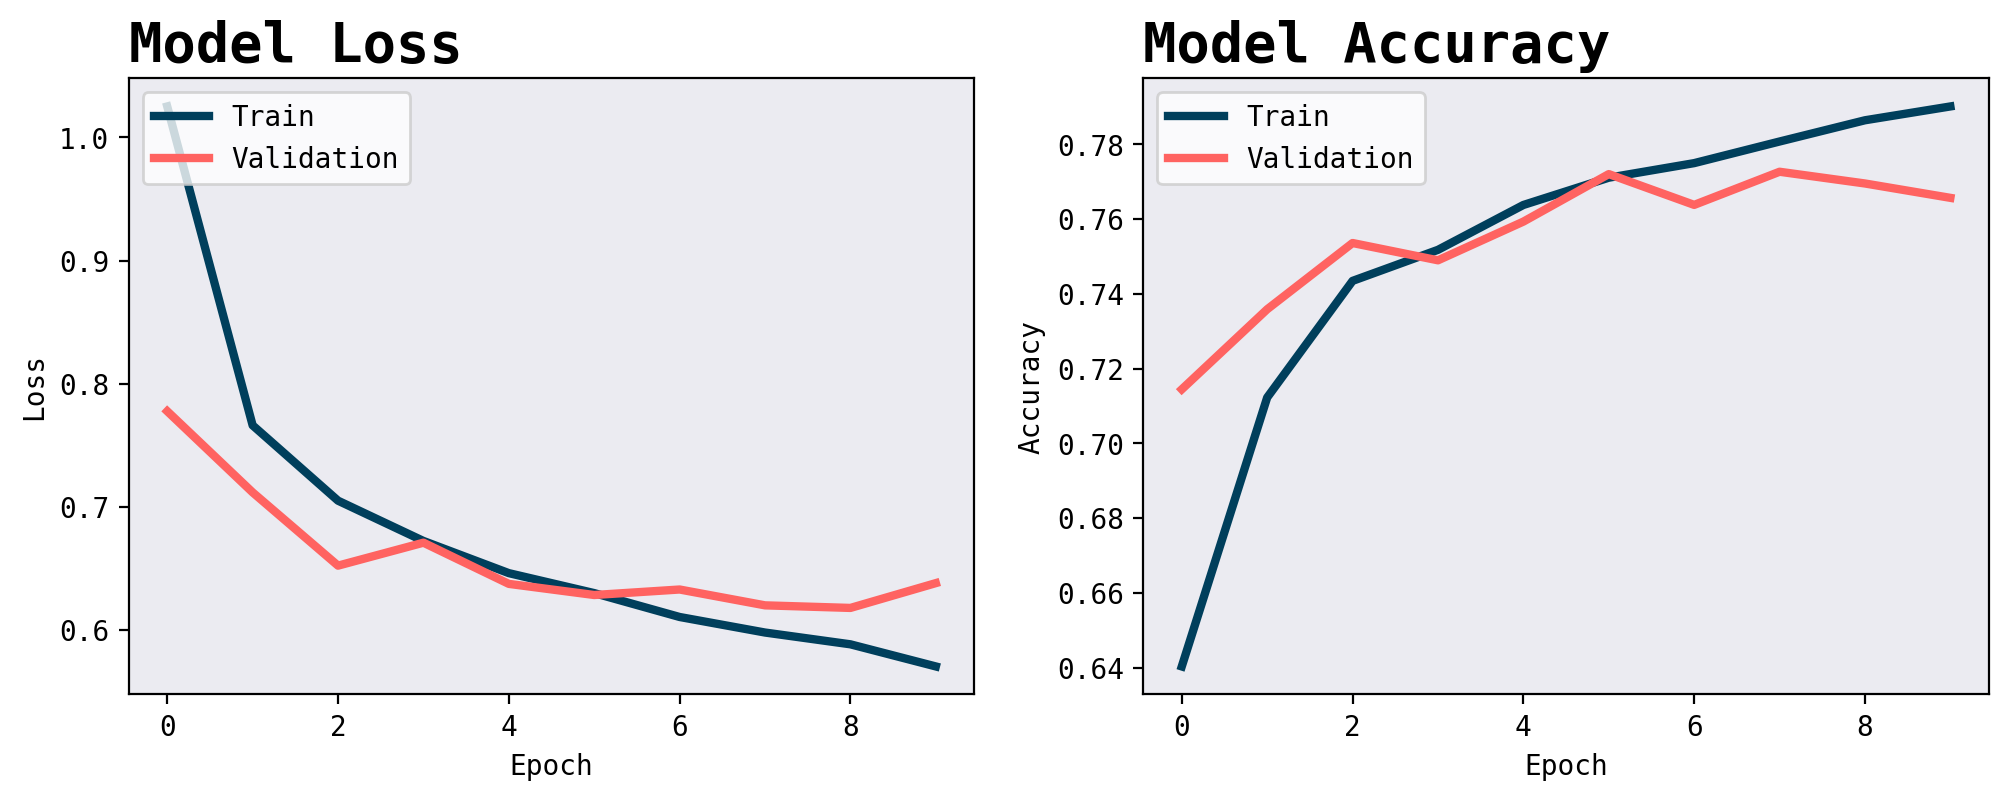

399/399 [==============================] - 11s 29ms/step


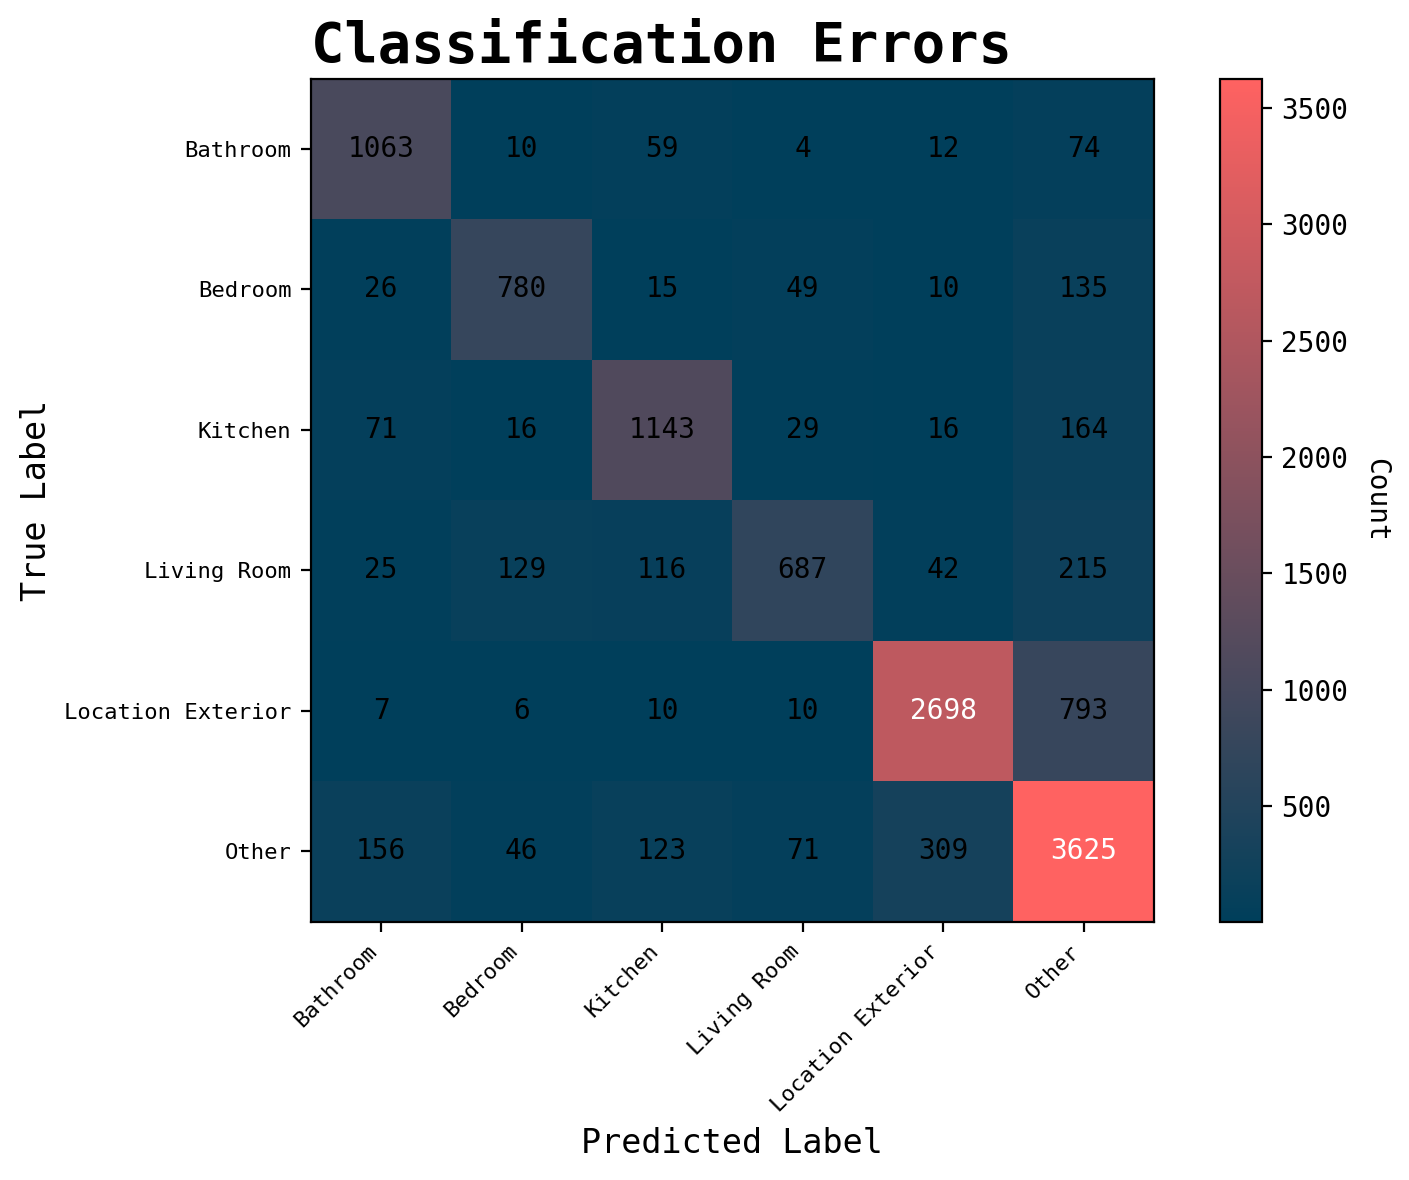

y
[5 5 1 ... 2 4 4]
labels
[0, 1, 2, 3, 4, 5]
inverse transformed labels
['Bathroom' 'Bedroom' 'Kitchen' 'Living Room' 'Location Exterior' 'Other']
1/1 [==============================] - 0s 146ms/step
preds
[[6.7282337e-05 1.4492364e-04 4.4198245e-05 6.8388952e-05 2.0303405e-04
  9.9947220e-01]]
1/1 [==============================] - 0s 23ms/step
preds
[[1.4617931e-04 1.3905355e-03 1.4461730e-04 3.7822474e-04 5.7150028e-04
  9.9736893e-01]]
1/1 [==============================] - 0s 22ms/step
preds
[[1.4883568e-04 9.9897552e-01 3.3117045e-04 1.4255301e-04 3.8942770e-04
  1.2488258e-05]]
1/1 [==============================] - 0s 23ms/step
preds
[[4.0016437e-04 1.8209302e-03 1.8369487e-02 9.3993998e-01 4.0013385e-03
  3.5468090e-02]]
1/1 [==============================] - 0s 23ms/step
preds
[[0.02566114 0.01030863 0.01618296 0.01163246 0.01077315 0.9254416 ]]
1/1 [==============================] - 0s 23ms/step
preds
[[9.1107591e-05 1.8864524e-04 2.2007484e-04 2.5586382e-04 9.8482436e-01
 

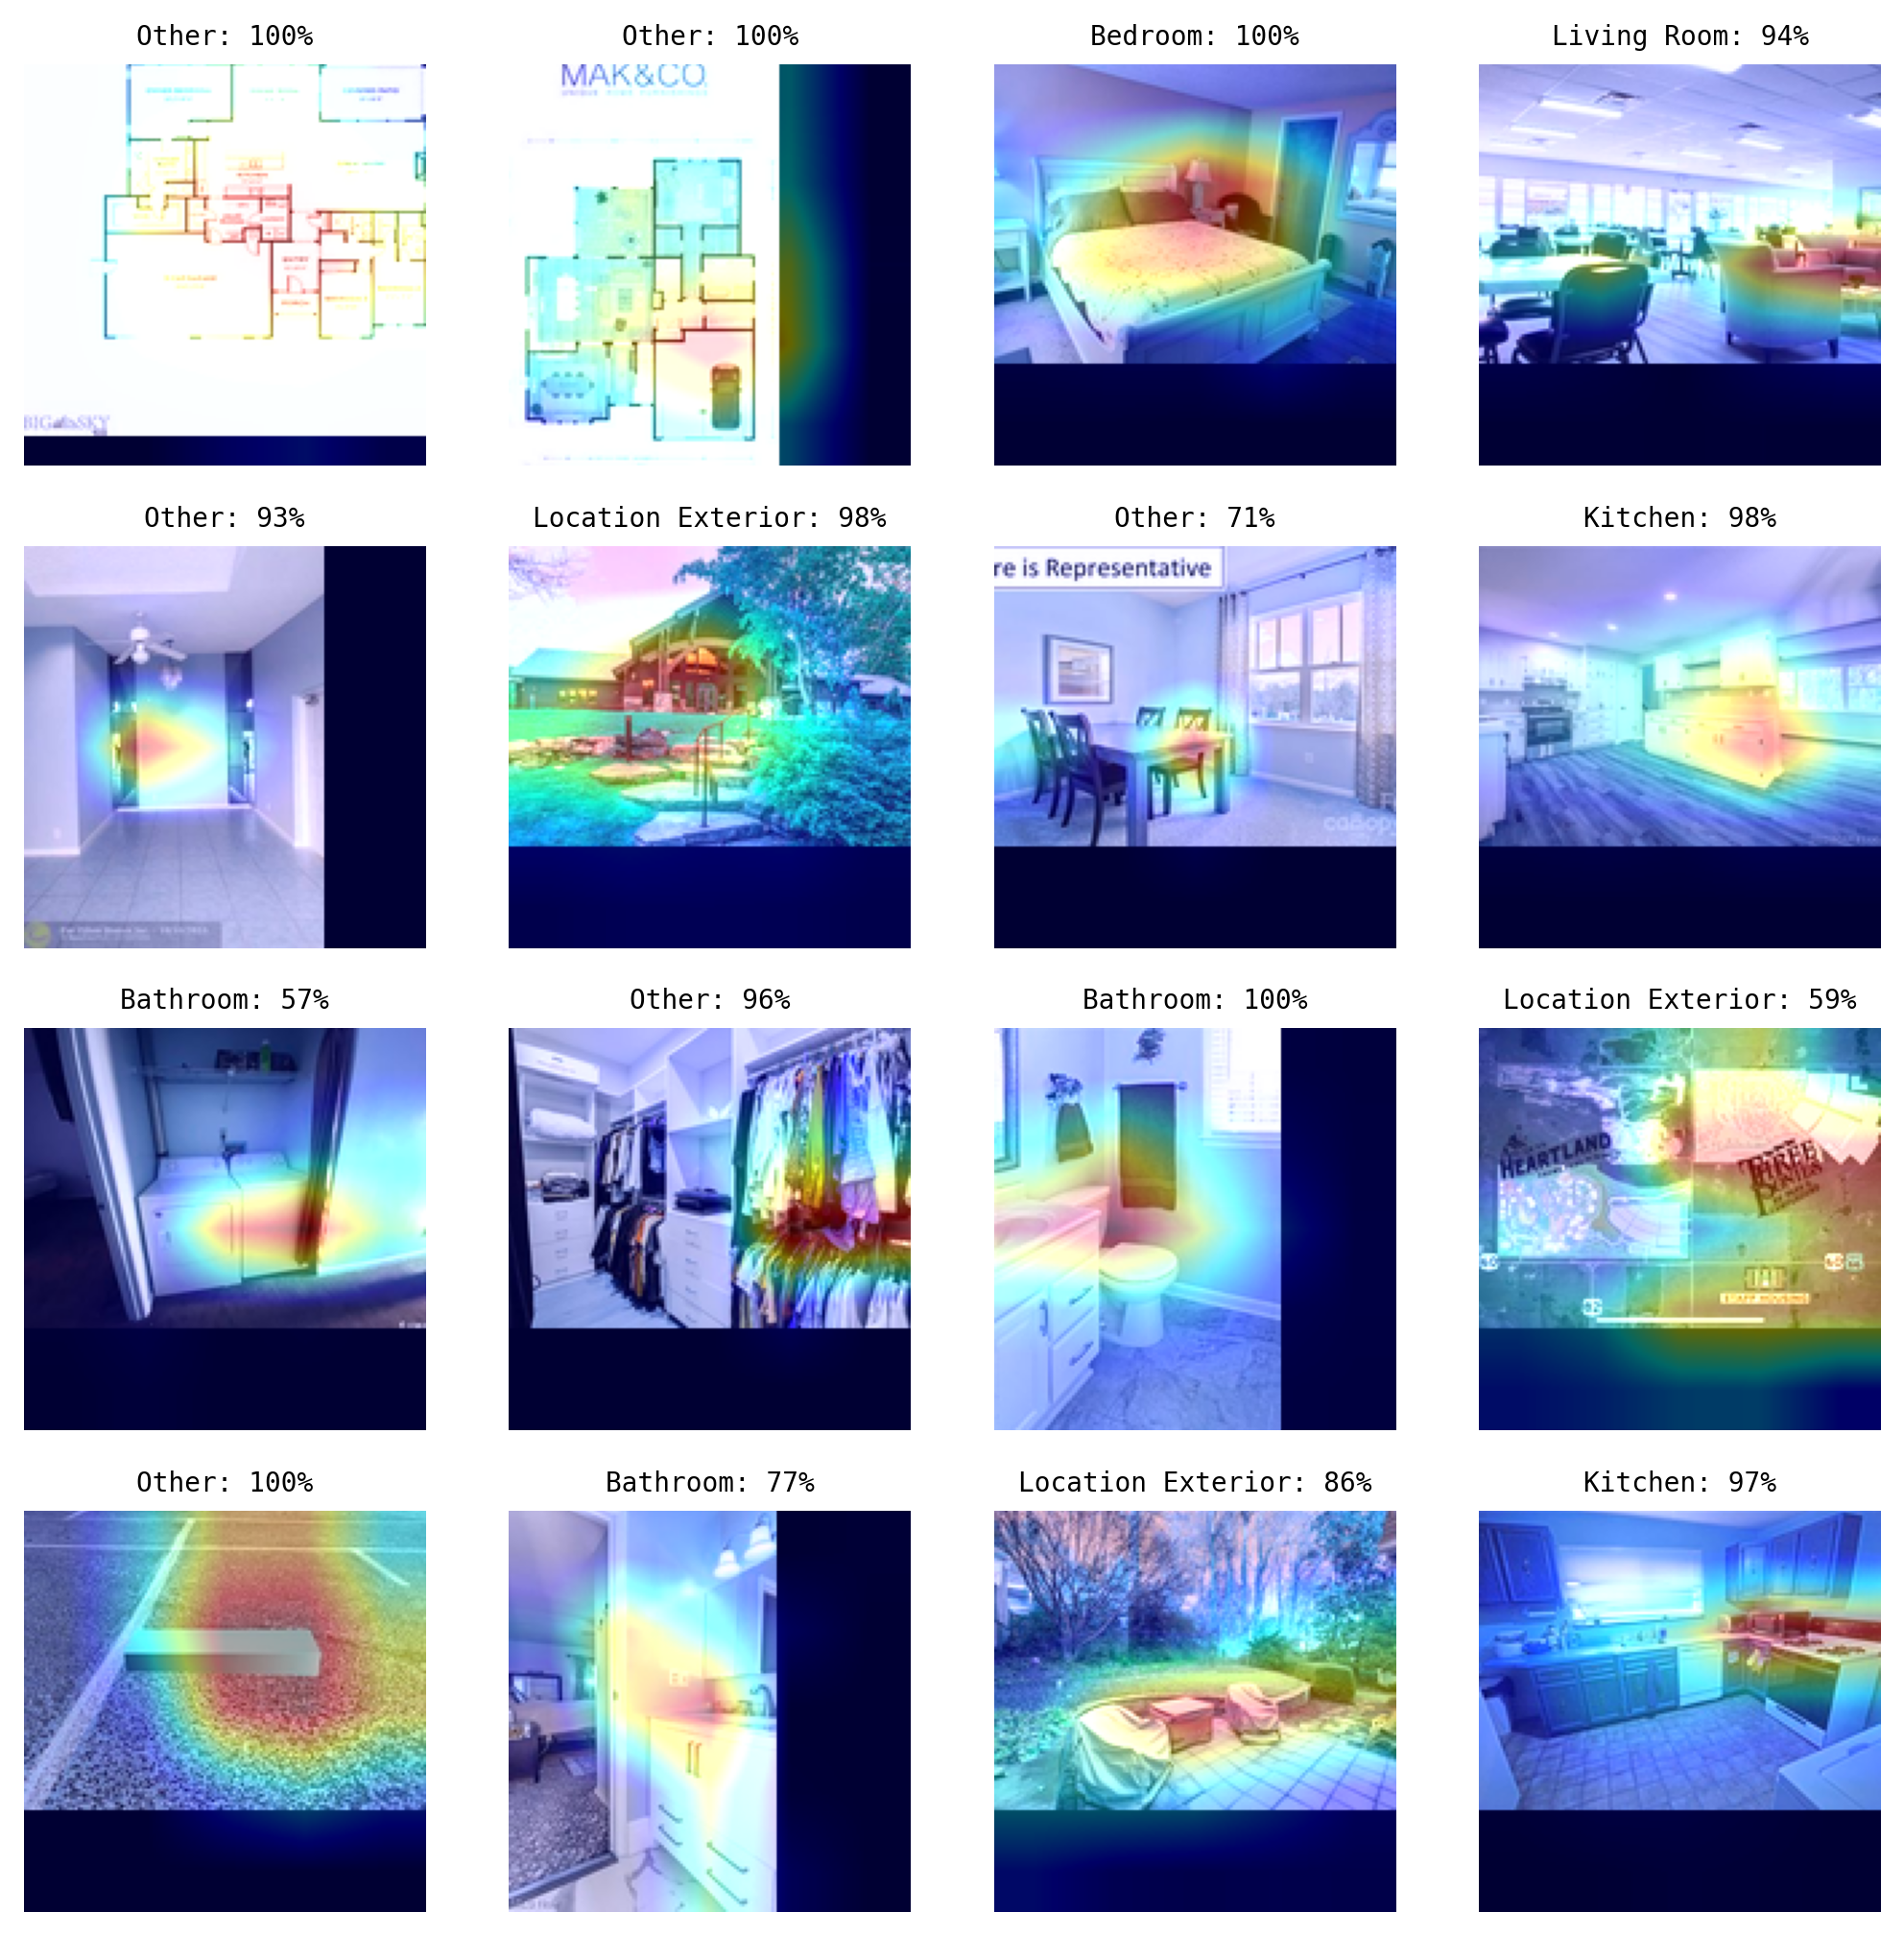

In [16]:
room_categorizer_model = build_model(
    name='room_categorizer',
    model_type='image_classification', 
    epochs=10, 
    n_classes=6,
    label=None
)

In [ ]:
bathroom_ranker_model = build_model(
    name='bathroom_ranker',
    model_type='image_rank', 
    epochs=10, 
    n_classes=10,
    label='Bathroom')

2024-11-24 14:59:53: loading data
2024-11-24 14:59:55: discarding inhomogeneous arrays
2024-11-24 14:59:55: limiting dataset
2024-11-24 14:59:55: preparing training data
2024-11-24 14:59:55: generating model
2024-11-24 14:59:57: generating training and validation generators
2024-11-24 14:59:57: training model
Epoch 1/10
58/58 [==============================] - 31s 426ms/step - loss: 25.8974 - mean_absolute_error: 4.5655 - val_loss: 95.5687 - val_mean_absolute_error: 8.6886
Epoch 2/10
58/58 [==============================] - 23s 400ms/step - loss: 16.7709 - mean_absolute_error: 3.5558 - val_loss: 23.0952 - val_mean_absolute_error: 4.1095
Epoch 3/10
58/58 [==============================] - 23s 395ms/step - loss: 10.0961 - mean_absolute_error: 2.6166 - val_loss: 41.4832 - val_mean_absolute_error: 4.1754
Epoch 4/10
58/58 [==============================] - 23s 401ms/step - loss: 6.8135 - mean_absolute_error: 2.0624 - val_loss: 7.8005 - val_mean_absolute_error: 2.1354
Epoch 5/10
58/58 [=====

47/47 [==============================] - 19s 399ms/step - loss: 6.4884 - mean_absolute_error: 1.9354 - val_loss: 9.5423 - val_mean_absolute_error: 2.0246
Epoch 6/10
47/47 [==============================] - 19s 395ms/step - loss: 5.3236 - mean_absolute_error: 1.7807 - val_loss: 3.9190 - val_mean_absolute_error: 1.4322
Epoch 7/10
47/47 [==============================] - 19s 401ms/step - loss: 5.3115 - mean_absolute_error: 1.7351 - val_loss: 2.4961 - val_mean_absolute_error: 1.1946
Epoch 8/10
47/47 [==============================] - 19s 396ms/step - loss: 4.5077 - mean_absolute_error: 1.6007 - val_loss: 3.1999 - val_mean_absolute_error: 1.3426
Epoch 9/10
47/47 [==============================] - 19s 414ms/step - loss: 4.4066 - mean_absolute_error: 1.5639 - val_loss: 2.2686 - val_mean_absolute_error: 1.1655
Epoch 10/10
47/47 [==============================] - 19s 396ms/step - loss: 4.1528 - mean_absolute_error: 1.5436 - val_loss: 2.2050 - val_mean_absolute_error: 1.1159
2024-11-24 15:07:32:

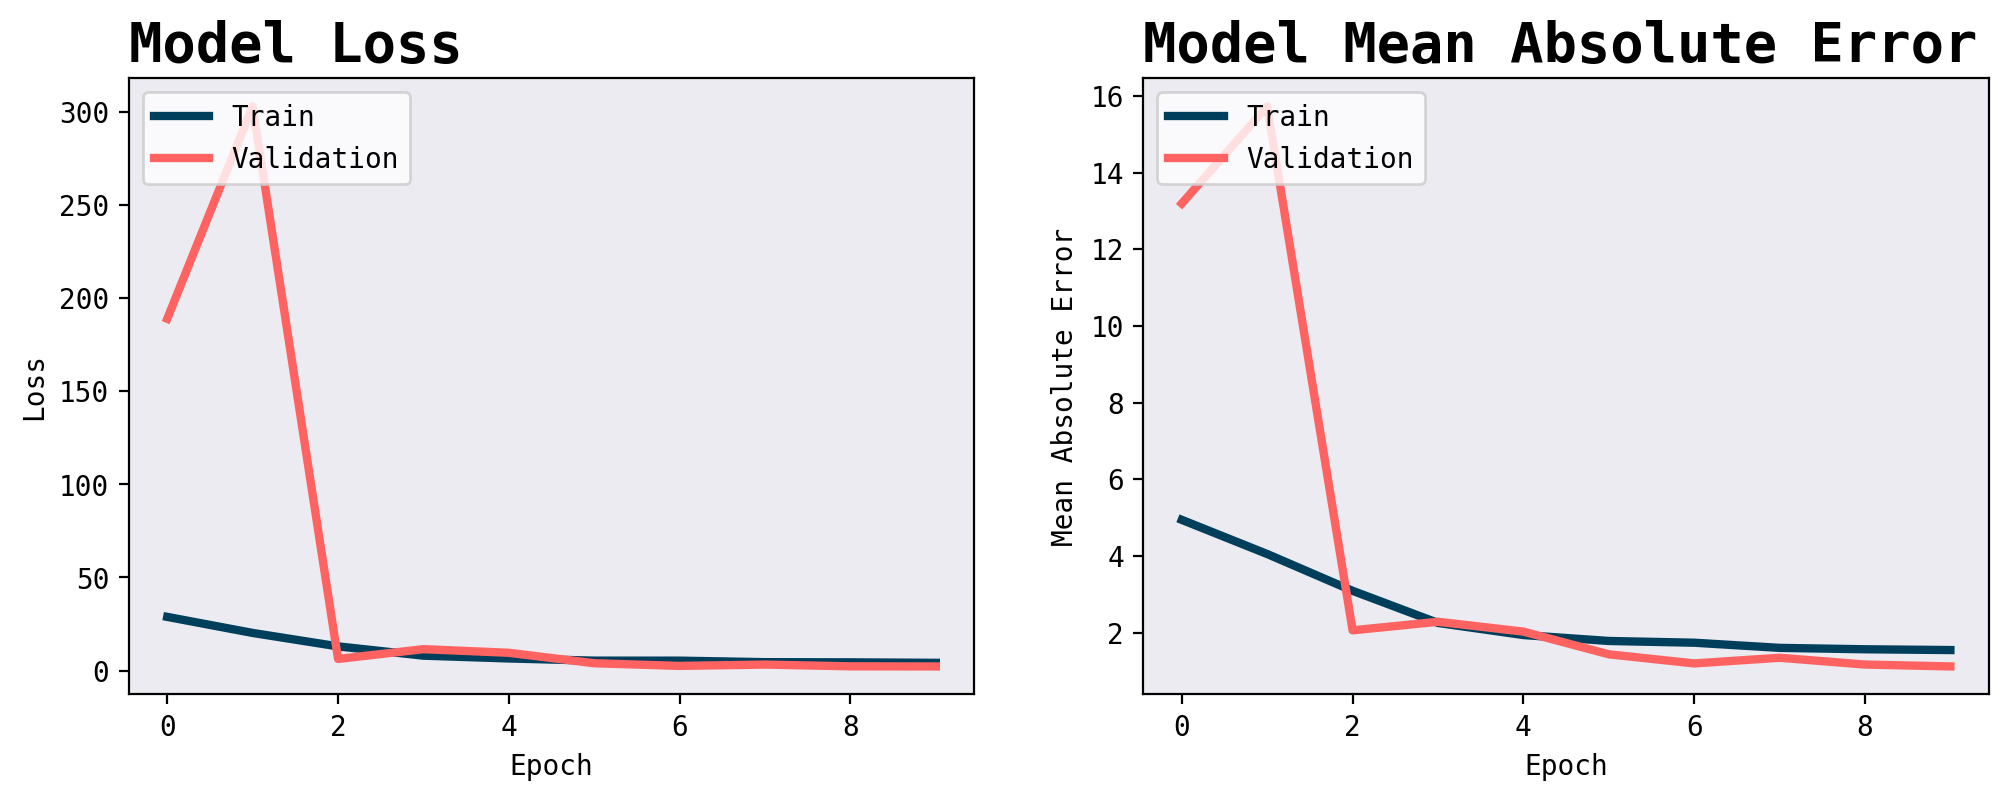

31/31 [==============================] - 1s 29ms/step


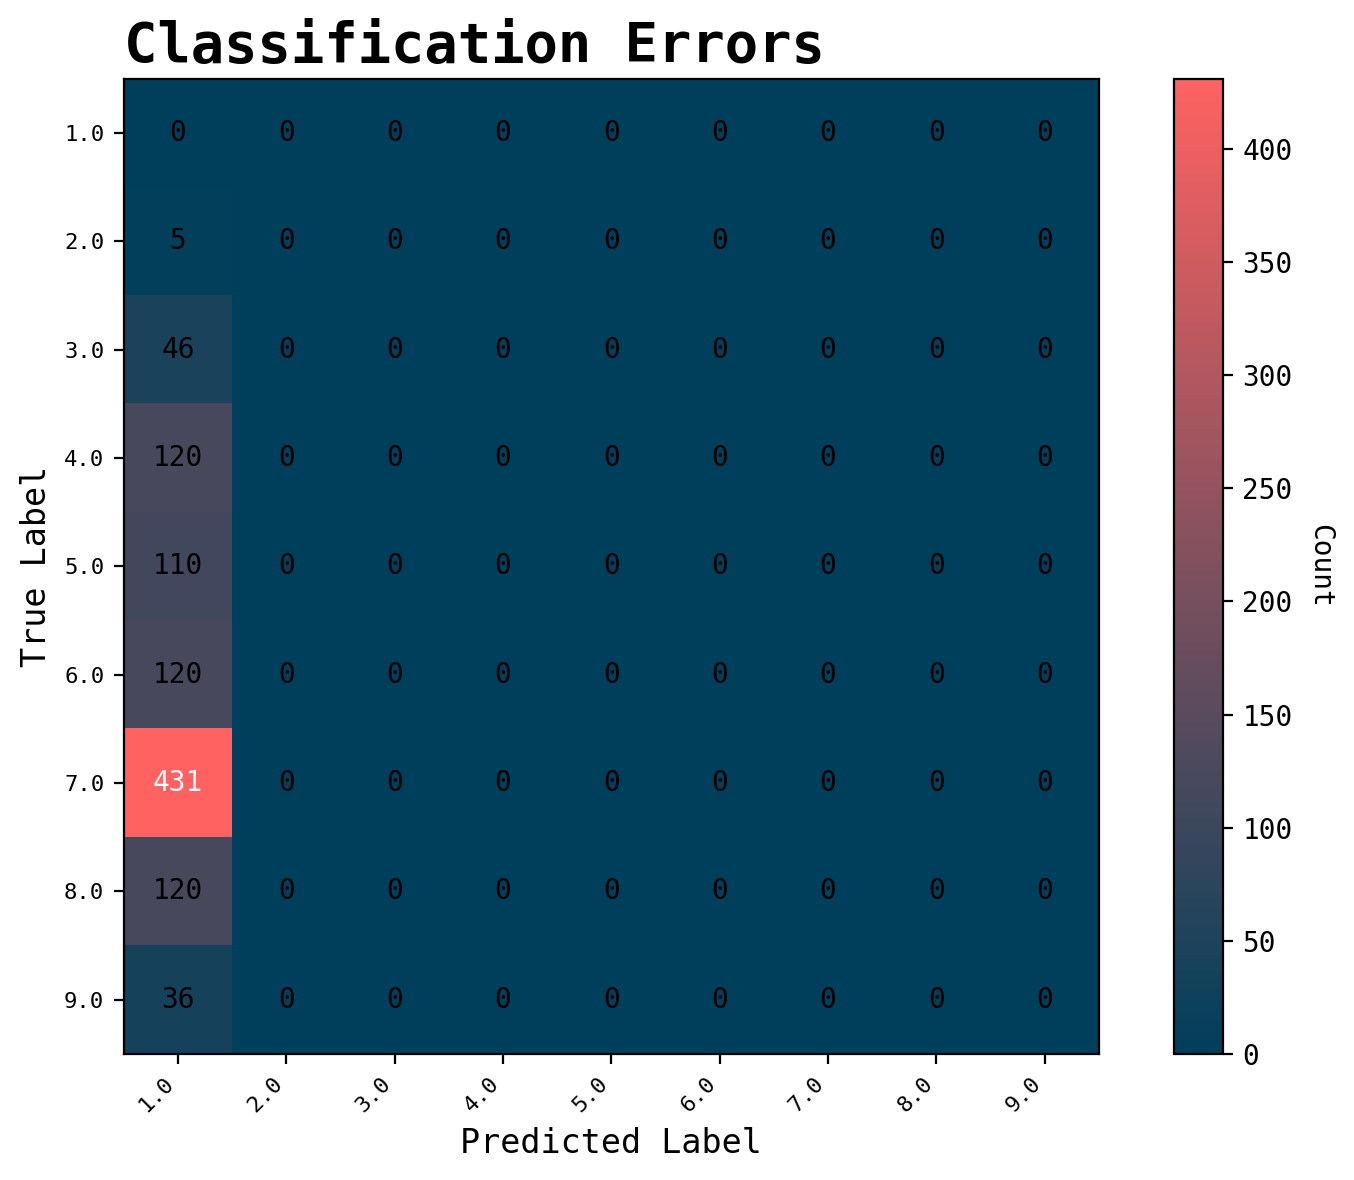

y
[6 5 3 2 6 6 3 5 3 7 7 6 6 3 6 6 6 7 6 6 6 7 5 6 6 3 3 6 6 8 3 6 3 3 4 8 4
 7 2 6 6 4 6 4 3 6 3 6 5 6 5 6 6 7 4 6 6 3 5 3 7 6 4 6 2 4 5 6 7 5 6 4 6 5
 2 5 4 3 3 5 3 6 3 6 6 6 6 7 5 6 3 6 4 6 3 6 2 6 3 6 8 4 5 3 5 7 5 7 5 4 4
 3 6 3 5 6 7 6 3 6 6 3 4 4 6 7 6 3 3 5 3 5 4 6 4 6 7 8 6 7 7 6 6 8 5 6 5 6
 2 5 4 7 6 6 7 6 5 6 6 3 6 4 4 6 3 8 6 4 5 7 3 5 6 7 6 6 6 5 4 6 5 6 5 3 6
 7 4 6 6 6 6 6 5 3 6 7 3 8 6 5 7 6 6 5 5 5 5 3 2 7 8 4 3 7 2 6 5 8 6 8 8 5
 5 8 3 6 3 4 6 5 3 7 3 6 5 3 6 6 2 6 7 6 6 6 7 2 6 8 6 3 7 6 6 6 6 6 6 7 5
 3 6 4 6 6 3 6 6 4 3 6 6 5 7 2 6 7 3 5 6 6 3 4 7 5 6 6 6 2 5 4 6 6 6 6 6 5
 5 6 6 4 6 3 6 6 6 6 4 6 4 6 4 5 6 5 4 5 4 7 6 5 6 5 6 6 5 8 6 7 5 6 6 4 5
 2 8 6 6 6 8 2 6 7 5 5 6 6 4 6 7 6 7 4 5 6 6 2 8 6 3 2 7 6 3 3 6 6 7 6 6 7
 6 7 8 7 6 3 3 6 3 6 7 4 3 5 3 4 5 7 6 4 4 6 5 6 6 4 2 5 5 4 6 4 6 5 7 4 6
 6 3 6 6 6 4 6 2 6 3 6 8 6 6 6 6 7 6 5 6 5 5 6 6 6 4 2 7 5 3 4 7 6 7 5 6 3
 6 7 8 6 8 1 7 8 6 6 6 5 6 6 6 5 2 4 6 6 5 6 3 6 6 3 6 3 6 7 6 7 7 6 6 6 6
 3 8 7 7 6 6 6 3 6 3 4 

In [ ]:
location_exterior_ranker_model = build_model(
    name='bedroom_ranker',
    model_type='image_rank', 
    epochs=10, 
    n_classes=10,
    label='Bedroom')

In [ ]:
kitchen_ranker_model = build_model(
    name='kitchen_ranker',
    model_type='image_rank', 
    epochs=10, 
    n_classes=10,
    label='Kitchen')

In [ ]:
living_room_ranker_model = build_model(
    name='living_room_ranker',
    model_type='image_rank', 
    epochs=10, 
    n_classes=10,
    label='Living Room')

168/168 [==============================] - 67s 400ms/step - loss: 3.6315 - mean_absolute_error: 1.4972 - val_loss: 2.7632 - val_mean_absolute_error: 1.2922
Epoch 7/10
168/168 [==============================] - 66s 393ms/step - loss: 3.3437 - mean_absolute_error: 1.4375 - val_loss: 2.6480 - val_mean_absolute_error: 1.2808
Epoch 8/10
168/168 [==============================] - 67s 397ms/step - loss: 3.0627 - mean_absolute_error: 1.3888 - val_loss: 2.6897 - val_mean_absolute_error: 1.3247
Epoch 9/10
168/168 [==============================] - 66s 395ms/step - loss: 3.0089 - mean_absolute_error: 1.3662 - val_loss: 2.5270 - val_mean_absolute_error: 1.2488
Epoch 10/10
168/168 [==============================] - 68s 403ms/step - loss: 2.8937 - mean_absolute_error: 1.3423 - val_loss: 2.5395 - val_mean_absolute_error: 1.2690
2024-11-24 15:28:16: calculating model performance
112/112 [==============================] - 4s 29ms/step
+-------+--------------------+--------------------+---------+
| Labe

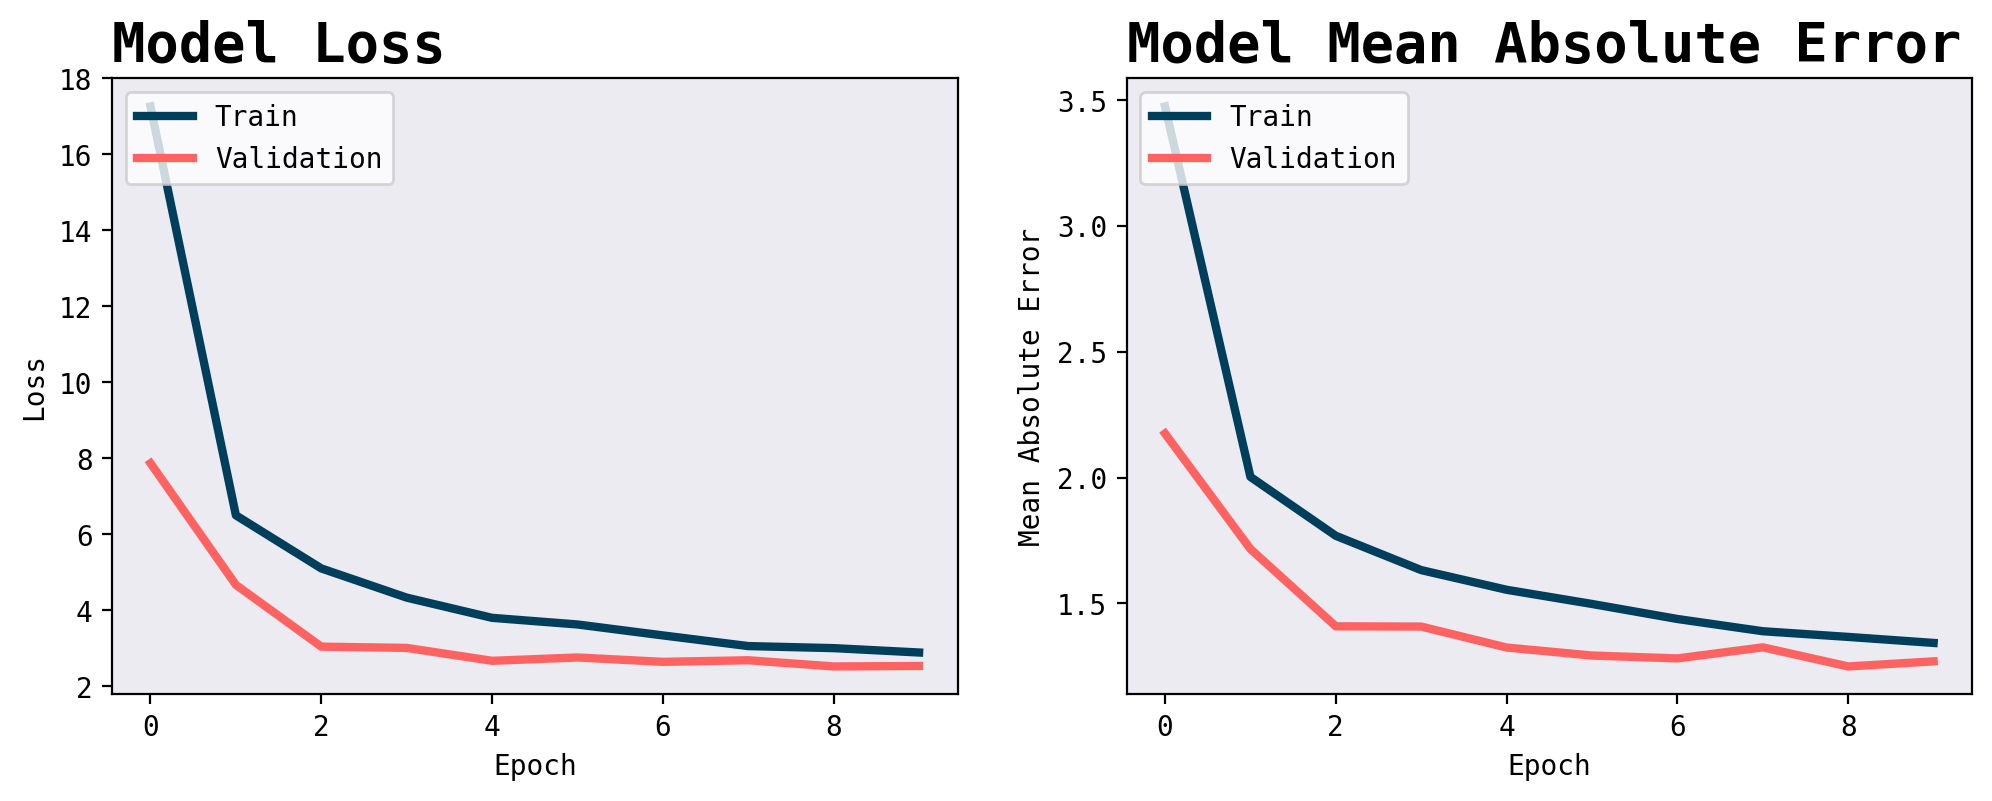

112/112 [==============================] - 3s 29ms/step


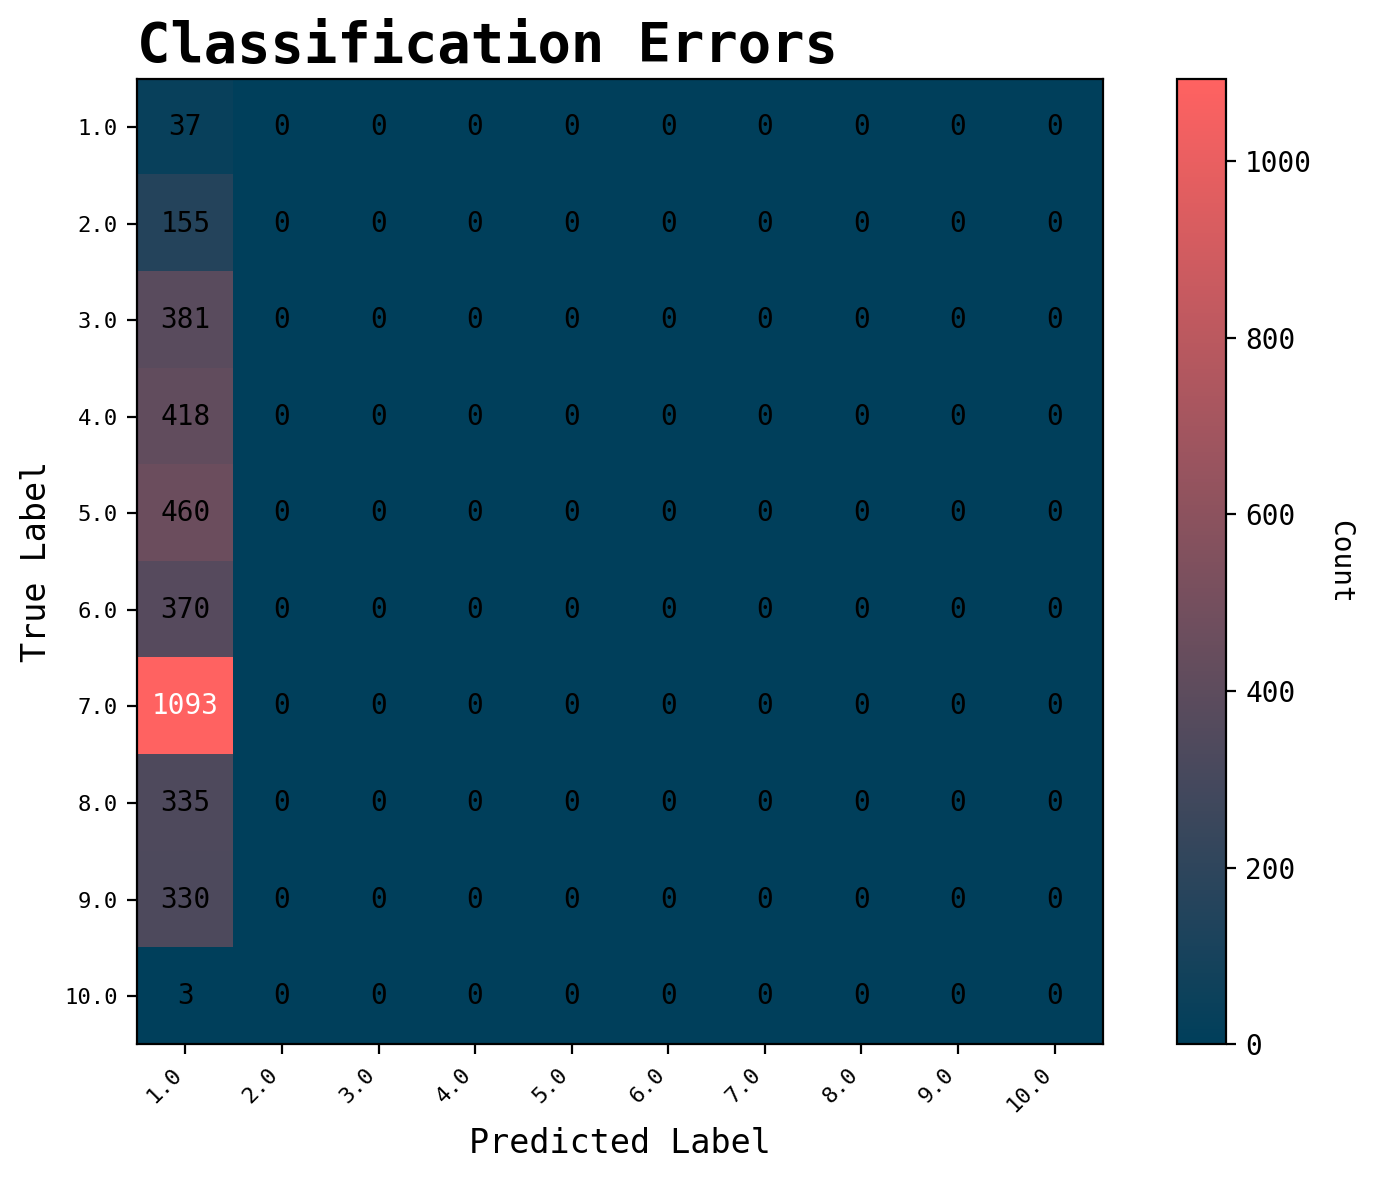

y
[8 3 6 ... 1 3 7]
labels
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
inverse transformed labels
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
1/1 [==============================] - 0s 23ms/step
preds
[[5.5693045]]
1/1 [==============================] - 0s 23ms/step
preds
[[4.558711]]
1/1 [==============================] - 0s 22ms/step
preds
[[5.206544]]
1/1 [==============================] - 0s 24ms/step
preds
[[4.975259]]
1/1 [==============================] - 0s 23ms/step
preds
[[1.529361]]
1/1 [==============================] - 0s 25ms/step
preds
[[5.683916]]
1/1 [==============================] - 0s 22ms/step
preds
[[6.172018]]
1/1 [==============================] - 0s 27ms/step
preds
[[6.2244387]]
1/1 [==============================] - 0s 23ms/step
preds
[[3.5126264]]
1/1 [==============================] - 0s 22ms/step
preds
[[5.743208]]
1/1 [==============================] - 0s 24ms/step
preds
[[4.2780046]]
1/1 [==============================] - 0s 23ms/step
preds
[[4.7772455]]
1/1 [===========

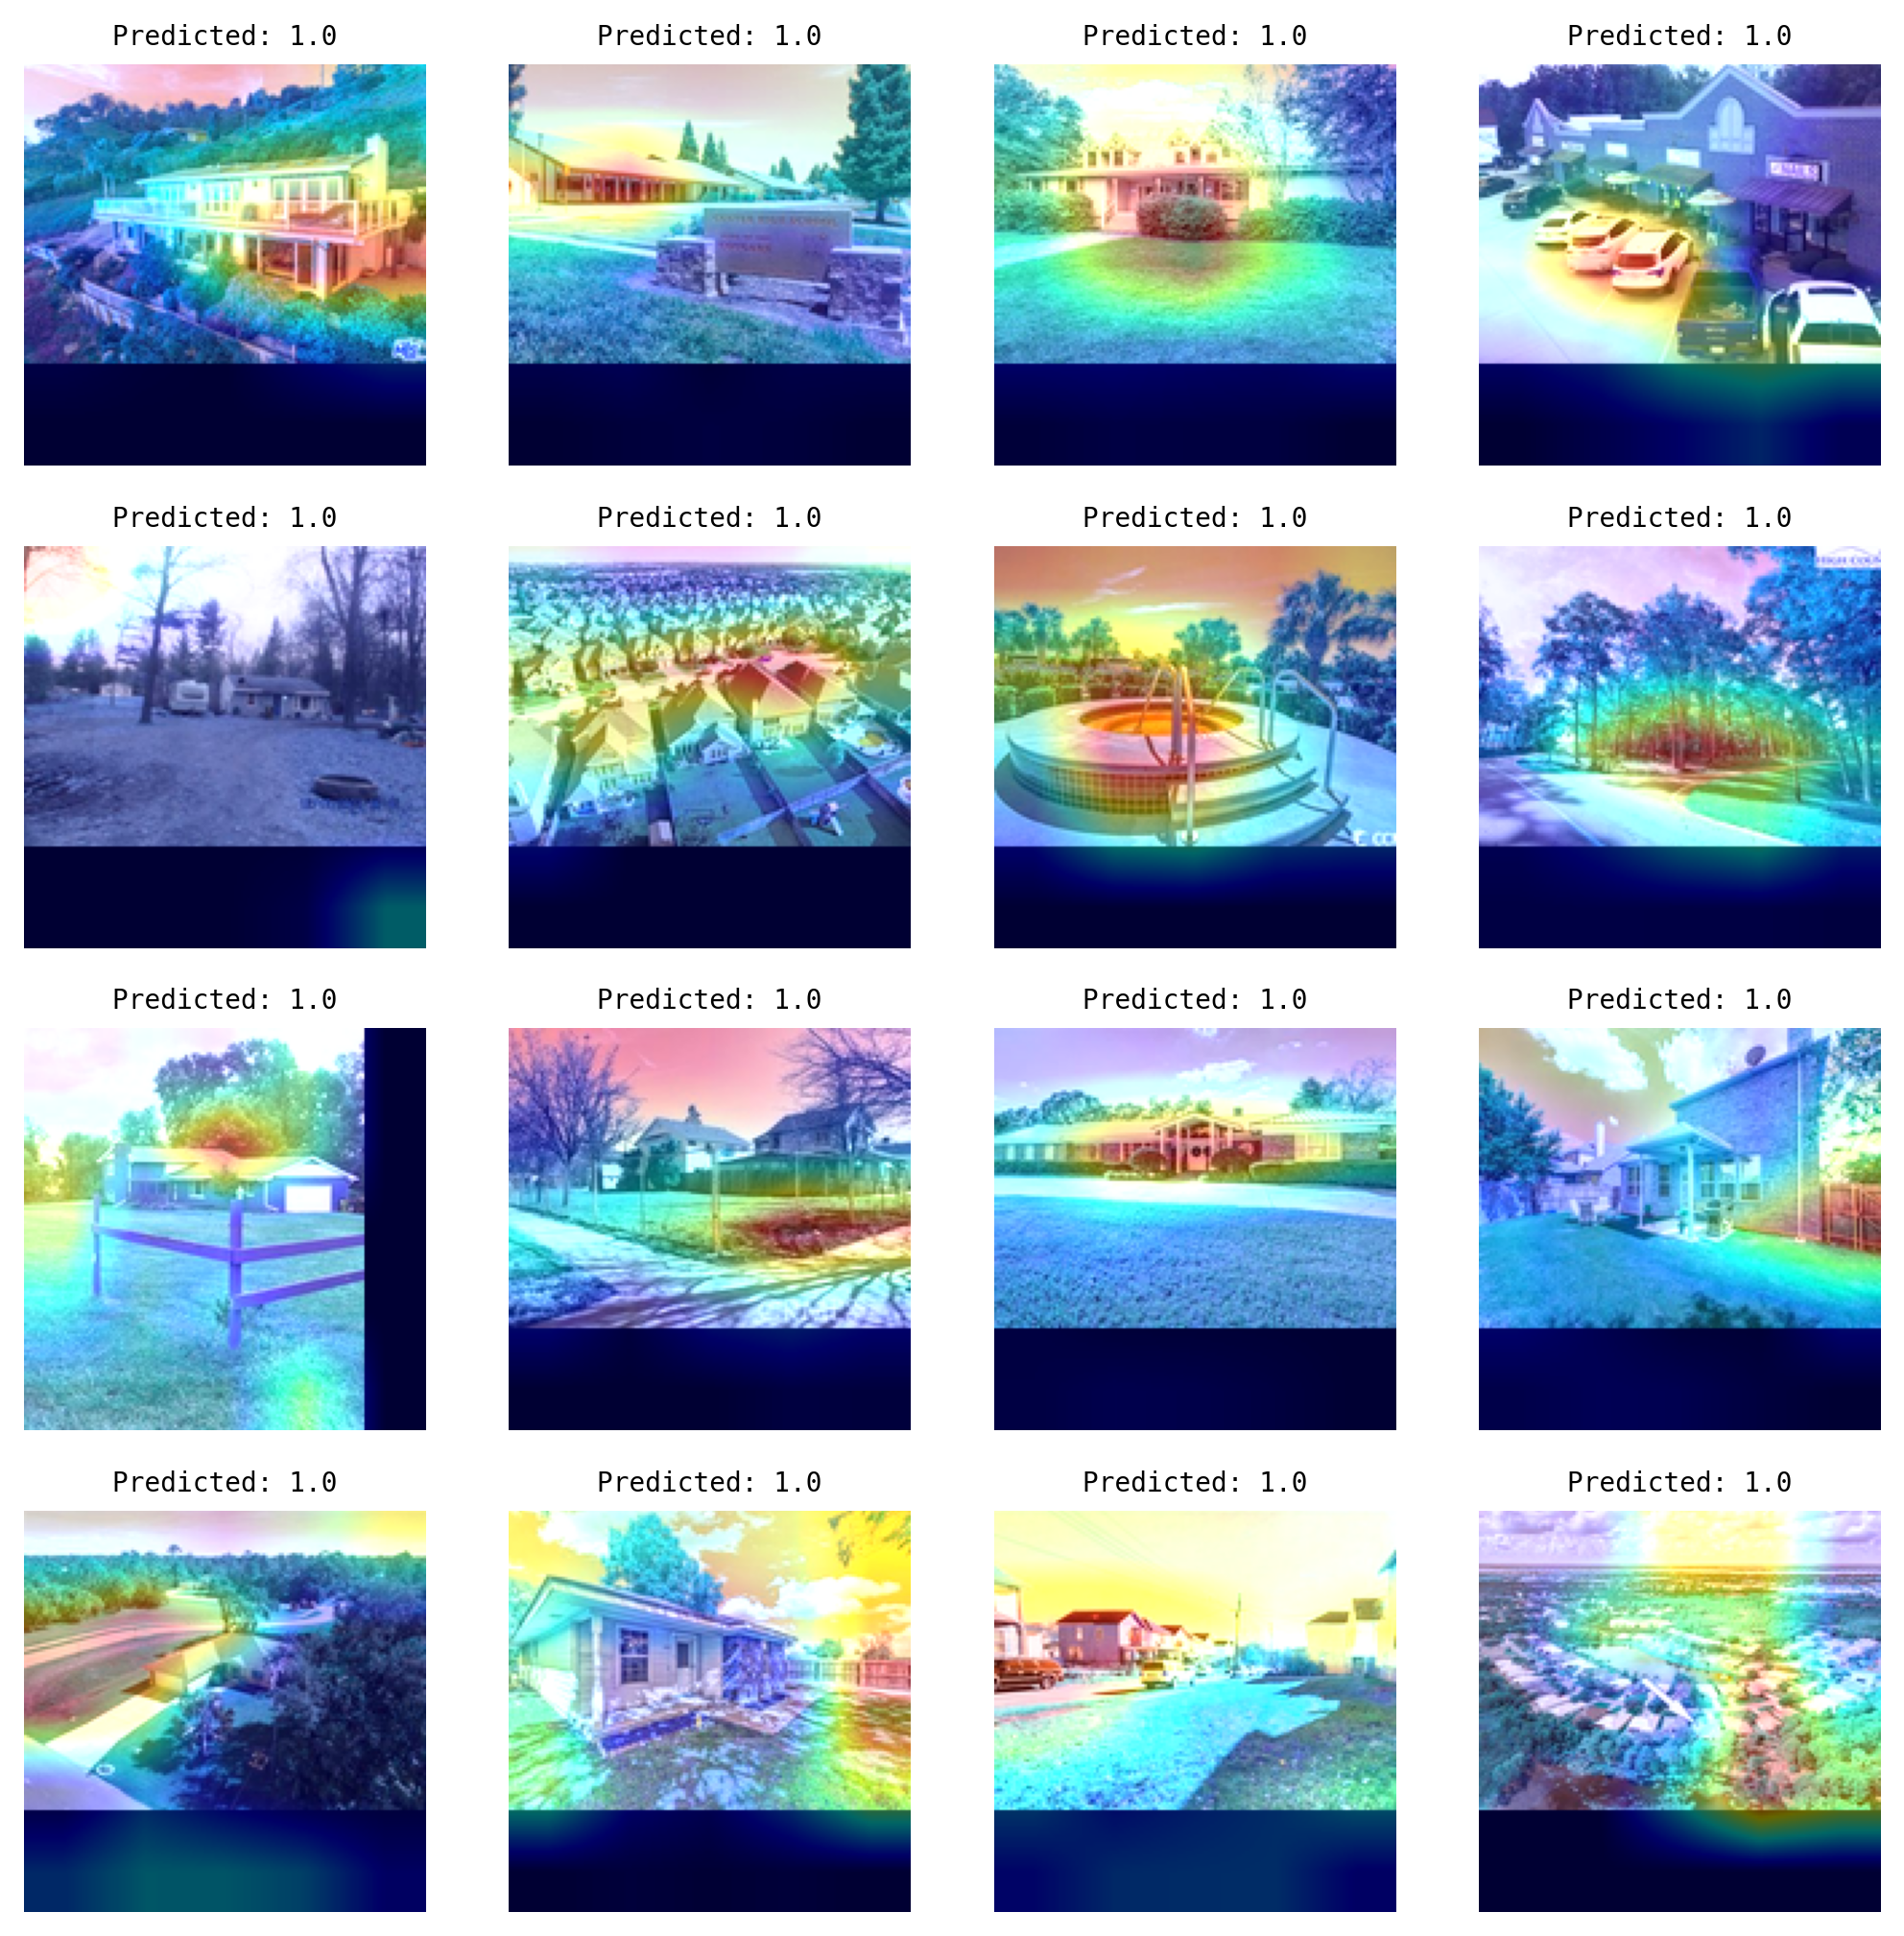

In [21]:
location_exterior_ranker_model = build_model(
    name='location_exterior_ranker',
    model_type='image_rank', 
    epochs=10, 
    n_classes=10,
    label='Location Exterior')